# Задача

*Проблематика:*

- В современных банках продуктовые команды имеют ограниченные ресурсы на техническую оптимизацию (например, 1 технический спринт в квартал). При этом отсутствует объективная информация о том, какие этапы кредитного процесса создают наибольшие задержки и влияют на общую скорость обработки заявок. Руководство не имеет инструментов для оценки эффективности проведенных оптимизаций и принятия решений о дальнейших направлениях развития. Системные аналитики вынуждены полагаться на субъективные оценки заинтересованных сторон вместо данных о реальной производительности системы.

 

*В рамках задачи необходимо:*

- Провести анализ AS-IS процесса: изучить предоставленную BPMN-модель кредитного процесса и датасет с временными метриками, выявить критические узкие места и проблемные участки.

# Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')



# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Загружаем данные основного процесса
main_process_data = pd.read_excel('Основной процесс расчета лимита.xlsx', sheet_name='Данные процесса')
main_tasks_ref = pd.read_excel('Основной процесс расчета лимита.xlsx', sheet_name='Справочник задач')
main_incidents = pd.read_excel('Основной процесс расчета лимита.xlsx', sheet_name='Инциденты')

# Загружаем данные подпроцесса БКИ
bki_process_data = pd.read_excel('Подпроцесс Обращения в БКИ.xlsx', sheet_name='Данные процесса')
bki_tasks_ref = pd.read_excel('Подпроцесс Обращения в БКИ.xlsx', sheet_name='Справочник задач')
bki_incidents = pd.read_excel('Подпроцесс Обращения в БКИ.xlsx', sheet_name='Инциденты')

print("Основной процесс - форма данных:", main_process_data.shape)
print("Подпроцесс БКИ - форма данных:", bki_process_data.shape)

Основной процесс - форма данных: (165999, 5)
Подпроцесс БКИ - форма данных: (85410, 5)


In [3]:
# Автосохранение графиков

def save_fig(name):
    plt.savefig(f'{name}.png', dpi=300, bbox_inches='tight')
    print(f"График сохранен как {name}.png")



# Предварительный анализ данных

In [4]:
def analyze_data_quality(df, df_name):
    initial_count = len(df)
    print(f"\n🔍 **АНАЛИЗ КАЧЕСТВА ДАННЫХ: {df_name.upper()}**")
    print(f"{'-'*40}")
    print(f"   Исходное количество записей: {initial_count:,}".replace(',', ' '))
    
    # Анализ пропусков в ключевых полях
    key_columns = ['application_id', 'element_id', 'start_date', 'end_date']
    missing_key_data = df[key_columns].isnull().sum()
    
    print(f"\n📊 **ПРОПУСКИ В КЛЮЧЕВЫХ ПОЛЯХ:**")
    total_missing = 0
    for col in key_columns:
        missing_count = missing_key_data[col]
        missing_percent = (missing_count / initial_count) * 100
        if missing_count > 0:
            print(f"   ⚠️  {col}: {missing_count:,} ({missing_percent:.1f}%)".replace(',', ' '))
            total_missing += missing_count
        else:
            print(f"   ✓ {col}: пропусков нет")
    
    # Анализ некорректных длительностей
    negative_time = len(df[df['duration_seconds'] <= 0])
    negative_percent = (negative_time / initial_count) * 100
    
    print(f"\n⏱️  **АНАЛИЗ ДЛИТЕЛЬНОСТЕЙ:**")
    print(f"   • Записей с отрицательной/нулевой длительностью: {negative_time:,} ({negative_percent:.1f}%)".replace(',', ' '))
    
    # Анализ выбросов
    duration_threshold = df['duration_seconds'].quantile(0.90)
    outliers = len(df[df['duration_seconds'] > duration_threshold])
    outliers_percent = (outliers / initial_count) * 100
    
    # Анализ выбросов
    duration_threshold_1 = df['duration_seconds'].quantile(0.95)
    outliers_1 = len(df[df['duration_seconds'] > duration_threshold_1])
    outliers_percent_1 = (outliers_1 / initial_count) * 100
    
    print(f"   • Выбросов (>90 процентиль): {outliers:,} ({outliers_percent:.1f}%)".replace(',', ' '))
    print(f"   • Порог выбросов: {duration_threshold:.2f} сек")
    
    print(f"   • Выбросов (>95 процентиль): {outliers_1:,} ({outliers_percent_1:.1f}%)".replace(',', ' '))
    print(f"   • Порог выбросов: {duration_threshold_1:.2f} сек")
    
    # Сводная статистика
    print(f"\n📈 **СВОДНАЯ СТАТИСТИКА ОЧИСТКИ:**")
    would_remove = total_missing + negative_time + outliers
    would_keep = initial_count - would_remove
    keep_percent = (would_keep / initial_count) * 100
    
    print(f"   • Всего было бы удалено записей: {would_remove:,} ({would_remove/initial_count*100:.1f}%)".replace(',', ' '))
    print(f"   • Осталось бы записей: {would_keep:,} ({keep_percent:.1f}%)".replace(',', ' '))
    
    return {
        'initial_count': initial_count,
        'missing_count': total_missing,
        'negative_duration': negative_time,
        'outliers': outliers,
        'would_keep': would_keep,
        'keep_percent': keep_percent
    }

print(f"\n{'='*60}")
print("📊 АНАЛИЗ КАЧЕСТВА ДАННЫХ")
print(f"{'='*60}")

# Анализируем оба набора данных
main_quality = analyze_data_quality(main_process_data, "Основной процесс")
bki_quality = analyze_data_quality(bki_process_data, "Подпроцесс БКИ")

# Сравнительная статистика
print(f"\n{'='*60}")
print("📋 СРАВНИТЕЛЬНАЯ СТАТИСТИКА")
print(f"{'='*60}")
print(f"Основной процесс: {main_quality['would_keep']:,} записей осталось бы ({main_quality['keep_percent']:.1f}%)".replace(',', ' '))
print(f"Подпроцесс БКИ: {bki_quality['would_keep']:,} записей осталось бы ({bki_quality['keep_percent']:.1f}%)".replace(',', ' '))


📊 АНАЛИЗ КАЧЕСТВА ДАННЫХ

🔍 **АНАЛИЗ КАЧЕСТВА ДАННЫХ: ОСНОВНОЙ ПРОЦЕСС**
----------------------------------------
   Исходное количество записей: 165 999

📊 **ПРОПУСКИ В КЛЮЧЕВЫХ ПОЛЯХ:**
   ✓ application_id: пропусков нет
   ✓ element_id: пропусков нет
   ✓ start_date: пропусков нет
   ✓ end_date: пропусков нет

⏱️  **АНАЛИЗ ДЛИТЕЛЬНОСТЕЙ:**
   • Записей с отрицательной/нулевой длительностью: 20 000 (12.0%)
   • Выбросов (>90 процентиль): 16 466 (9.9%)
   • Порог выбросов: 78.00 сек
   • Выбросов (>95 процентиль): 8 272 (5.0%)
   • Порог выбросов: 143.00 сек

📈 **СВОДНАЯ СТАТИСТИКА ОЧИСТКИ:**
   • Всего было бы удалено записей: 36 466 (22.0%)
   • Осталось бы записей: 129 533 (78.0%)

🔍 **АНАЛИЗ КАЧЕСТВА ДАННЫХ: ПОДПРОЦЕСС БКИ**
----------------------------------------
   Исходное количество записей: 85 410

📊 **ПРОПУСКИ В КЛЮЧЕВЫХ ПОЛЯХ:**
   ✓ application_id: пропусков нет
   ✓ element_id: пропусков нет
   ✓ start_date: пропусков нет
   ✓ end_date: пропусков нет

⏱️  **АНАЛИЗ ДЛИТЕ


### **Краткий вывод: Данные для приоритизации оптимизации**

**Ключевой инсайт:**
- **Подпроцесс БКИ является главным кандидатом на оптимизацию.** Он не только имеет наихудшее качество данных (после очистки теряется 32% записей), но и значительные задержки (порог выбросов в 245 сек. существенно выше, чем в основном процессе).

**Рекомендация:**
**Начать оптимизацию с подпроцесса БКИ.** Исправив его, мы устраним главное "узкое место" и получим измеримый результат, который оправдает выделение ресурсов на дальнейшие улучшения.

# Очистка данных

In [5]:
# убираем явные мусорные записи (отрицательное время, нулевые длительности без статуса)

def clean_process_data(df):
    # Удаляем записи с пропусками в ключевых полях
    df_clean = df.dropna(subset=['application_id', 'element_id', 'start_date', 'end_date'])
    
    # Удаляем записи с отрицательным временем
    df_clean = df_clean[df_clean['duration_seconds'] > 0]
    
    return df_clean

main_process_data = clean_process_data(main_process_data)
bki_process_data = clean_process_data(bki_process_data)

print(main_process_data.shape[0])
print(bki_process_data.shape[0])


145999
66430


# Обьединение датафреймов 

In [6]:
# Добавляем incident_count в основные данные процесса
incident_keys = set(main_incidents[['application_id', 'element_id']].itertuples(index=False, name=None))

# Добавляем столбец incident_count в main_process_data
main_process_data['incident_count'] = main_process_data.apply(
    lambda row: 1 if (row['application_id'], row['element_id']) in incident_keys else 0,
    axis=1
)

# Для BKI данных
if not bki_incidents.empty:
    incident_key = set(bki_incidents[['application_id', 'element_id']].itertuples(index=False, name=None))
    bki_process_data['incident_count'] = bki_process_data.apply(
        lambda row: 1 if (row['application_id'], row['element_id']) in incident_key else 0,
        axis=1
    )
else:
    bki_process_data['incident_count'] = 0

# Добавляем тип процесса
main_process_data['process_type'] = 'main'
bki_process_data['process_type'] = 'bki'

# ОБЪЕДИНЯЕМ С СПРАВОЧНИКАМИ ЭЛЕМЕНТОВ

# Объединяем main_process_data с main_tasks_ref по element_id
main_enriched = main_process_data.merge(
    main_tasks_ref[['element_id', 'element_name']], 
    on='element_id', 
    how='left'
)

# Объединяем bki_process_data с bki_tasks_ref по element_id  
bki_enriched = bki_process_data.merge(
    bki_tasks_ref[['element_id', 'element_name']],
    on='element_id',
    how='left'
)

# Заполняем пропущенные названия элементов (если есть)
main_enriched['element_name'] = main_enriched['element_name'].fillna(main_enriched['element_id'])
bki_enriched['element_name'] = bki_enriched['element_name'].fillna(bki_enriched['element_id'])

# ОБЪЕДИНЯЕМ ВСЕ ДАННЫЕ В ОДНУ ТАБЛИЦУ
full_process_data = pd.concat([main_enriched, bki_enriched], ignore_index=True)

print("Объединенные данные со справочниками:")
print(f"Размер: {full_process_data.shape}")
print(f"Колонки: {full_process_data.columns.tolist()}")
print(f"\nТипы процессов: {full_process_data['process_type'].value_counts().to_dict()}")
print(f"Уникальных элементов: {full_process_data['element_id'].nunique()}")
print(f"Уникальных названий: {full_process_data['element_name'].nunique()}")



Объединенные данные со справочниками:
Размер: (212429, 8)
Колонки: ['application_id', 'element_id', 'start_date', 'end_date', 'duration_seconds', 'incident_count', 'process_type', 'element_name']

Типы процессов: {'main': 145999, 'bki': 66430}
Уникальных элементов: 26
Уникальных названий: 24


# Расчет базовых метрик по элементам

In [7]:
#анализ временных паттернов
full_process_data['start_date'] = pd.to_datetime(full_process_data['start_date'])
full_process_data['hour'] = full_process_data['start_date'].dt.hour
full_process_data['day_of_week'] = full_process_data['start_date'].dt.dayofweek
full_process_data['month'] = full_process_data['start_date'].dt.month

# Анализ по часам и дням недели
hourly_metrics = full_process_data.groupby('hour').agg({
    'duration_seconds': 'mean',
    'application_id': 'count'
}).rename(columns={'application_id': 'requests_count'})

daily_metrics = full_process_data.groupby('day_of_week').agg({
    'duration_seconds': 'mean', 
    'application_id': 'count'
}).rename(columns={'application_id': 'requests_count'})

print("📈 МЕТРИКИ ПО ЧАСАМ СУТОК:")
print(hourly_metrics.round(2))
print("\n" + "="*50 + "\n")

print("📅 МЕТРИКИ ПО ДНЯМ НЕДЕЛИ:")
print(daily_metrics.round(2))

📈 МЕТРИКИ ПО ЧАСАМ СУТОК:
      duration_seconds  requests_count
hour                                  
0                54.01            9441
1                52.70            9808
2                52.62            8508
3                53.14            8875
4                52.41            9046
5                50.80            8907
6                55.48            8488
7                50.53            8499
8                54.91            9461
9                50.80            9076
10               52.73            8754
11               51.29            8742
12               50.79            9126
13               54.57            8672
14               51.55            8539
15               54.48            8491
16               50.60            8564
17               51.01            8480
18               51.41            8552
19               52.90            8687
20               53.68            9190
21               55.05            8882
22               50.15            8801

In [8]:
# анализ последовательностей процессов
def analyze_process_sequences(df):
    sequences = df.sort_values(['application_id', 'start_date']).groupby('application_id')['element_id'].apply(list)
    return sequences

# Поиск наиболее частых последовательностей
from collections import Counter

def find_common_sequences(sequences, top_n=10):
    sequence_counter = Counter(map(tuple, sequences))
    return sequence_counter.most_common(top_n)

# Применение
sequences = analyze_process_sequences(full_process_data)
common_sequences = find_common_sequences(sequences)
print("Топ-10 наиболее частых последовательностей:")
for seq, count in common_sequences:
    print(f"Последовательность: {seq[:5]}... - {count} выполнений")

Топ-10 наиболее частых последовательностей:
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 1572 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 1114 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 853 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 722 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 716 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Activity_05x71h2', 'Activity_033yu25')... - 510 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 503 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gateway_1yrkm1p', 'Gateway_0h0kb6b', 'n3')... - 337 выполнений
Последовательность: ('Activity_00jbzhh', 'n2', 'Gat

In [9]:
def calculate_element_metrics(df, incidents_df):
    """
    Расчет метрик производительности и надежности элементов процесса
    """
    # Базовые метрики выполнения
    element_metrics = df.groupby(['element_id', 'element_name']).agg({
        'duration_seconds': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'application_id': 'nunique'
    }).round(2)
    
    # Упрощаем названия колонок
    element_metrics.columns = [
        'count_executions', 'mean_duration', 'median_duration', 
        'std_duration', 'min_duration', 'max_duration', 'unique_applications'
    ]
    element_metrics = element_metrics.reset_index()
    
    # Расчет весов
    total_executions = element_metrics['count_executions'].sum()
    element_metrics['weight'] = (element_metrics['count_executions'] / total_executions).round(4)
    
    # Метрики инцидентов
    incident_metrics = incidents_df.groupby('element_id').agg({
        'error_trace': 'count'
    }).reset_index()
    incident_metrics.columns = ['element_id', 'incident_count']
    
    # Объединение метрик
    element_metrics = element_metrics.merge(incident_metrics, on='element_id', how='left')
    element_metrics['incident_count'] = element_metrics['incident_count'].fillna(0).astype(int)
    
    # KPI надежности
    element_metrics['kpi_no_incidents'] = round(
        (1 - element_metrics['incident_count'] / element_metrics['count_executions']) * 100, 2
    )
    
    return element_metrics

def display_top_elements(df, metric, n=10, title="", columns=None):
    """
    функция для отображения топ-элементов
    """
    if columns is None:
        columns = ['element_name', 'count_executions', 'mean_duration', 'incident_count', 'kpi_no_incidents']
    
   
    available_columns = [col for col in columns if col in df.columns]
    top_elements = df.nlargest(n, metric)[available_columns]
    
    print("\n" + "="*60)
    print(title)
    print("="*60)
    print(top_elements.to_string(index=False, float_format='%.2f', max_colwidth=30))

# Объединение данных об инцидентах
all_incidents = pd.concat([main_incidents, bki_incidents], ignore_index=True)
print(f"📁 Объединено инцидентов: {len(all_incidents)}")

# Расчет метрик
element_metrics = calculate_element_metrics(full_process_data, all_incidents)

# Вывод результатов
display_top_elements(
    element_metrics, 
    metric='count_executions',
    n=10,
    title="📊 ТОП-10 ЭЛЕМЕНТОВ ПО КОЛИЧЕСТВУ ВЫПОЛНЕНИЙ"
)

display_top_elements(
    element_metrics,
    metric='mean_duration', 
    n=10,
    title="🐌 ТОП-10 САМЫХ МЕДЛЕННЫХ ЭЛЕМЕНТОВ"
)

display_top_elements(
    element_metrics,
    metric='incident_count',
    n=10,
    title="⚠️ ТОП-10 ЭЛЕМЕНТОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ИНЦИДЕНТОВ"
)

# Топ-5 самых нестабильных элементов
if 'std_duration' in element_metrics.columns:
    display_top_elements(
        element_metrics,
        metric='std_duration',
        n=5,
        title="📈 ТОП-5 САМЫХ НЕСТАБИЛЬНЫХ ЭЛЕМЕНТОВ",
        columns=['element_name', 'std_duration', 'mean_duration', 'count_executions']
    )

📁 Объединено инцидентов: 23

📊 ТОП-10 ЭЛЕМЕНТОВ ПО КОЛИЧЕСТВУ ВЫПОЛНЕНИЙ
                  element_name  count_executions  mean_duration  incident_count  kpi_no_incidents
               Начало процесса             10000           5.99               0            100.00
            Данных достаточно?             10000           1.50               0            100.00
Проверить сведения клиента ...             10000          19.51               0            100.00
                 Конец расчета              9977           6.00               0            100.00
            Обратиться в БКИ 2              9490          79.58               0            100.00
     Сформировать заявку в БКИ              9490         239.12               0            100.00
            Обратиться в БКИ 1              9490          59.61               0            100.00
Обращение в Бюро кредитных ...              9490         209.92               0            100.00
            Обратиться в БКИ 3              9

In [10]:
print("🕒 АНАЛИЗ ВРЕМЕННЫХ РЯДОВ")
print("="*60)

# Анализ по часам
print("\n📊 ПИКОВЫЕ ЧАСЫ НАГРУЗКИ:")
peak_hour = hourly_metrics['requests_count'].idxmax()
print(f"• Самый загруженный час: {peak_hour}:00 ({hourly_metrics.loc[peak_hour, 'requests_count']} заявок)")
print(f"• Среднее время в пиковый час: {hourly_metrics.loc[peak_hour, 'duration_seconds']:.1f} сек")

# Самый быстрый и медленный час
fastest_hour = hourly_metrics['duration_seconds'].idxmin()
slowest_hour = hourly_metrics['duration_seconds'].idxmax()
print(f"• Самый быстрый час: {fastest_hour}:00 ({hourly_metrics.loc[fastest_hour, 'duration_seconds']:.1f} сек)")
print(f"• Самый медленный час: {slowest_hour}:00 ({hourly_metrics.loc[slowest_hour, 'duration_seconds']:.1f} сек)")

# Анализ по дням недели
days_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
           4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

print("\n📅 ЗАГРУЗКА ПО ДНЯМ НЕДЕЛИ:")
busiest_day = daily_metrics['requests_count'].idxmax()
slowest_day = daily_metrics['duration_seconds'].idxmax()
print(f"• Самый загруженный день: {days_map[busiest_day]} ({daily_metrics.loc[busiest_day, 'requests_count']} заявок)")
print(f"• Самый медленный день: {days_map[slowest_day]} ({daily_metrics.loc[slowest_day, 'duration_seconds']:.1f} сек)")

🕒 АНАЛИЗ ВРЕМЕННЫХ РЯДОВ

📊 ПИКОВЫЕ ЧАСЫ НАГРУЗКИ:
• Самый загруженный час: 1:00 (9808 заявок)
• Среднее время в пиковый час: 52.7 сек
• Самый быстрый час: 22:00 (50.2 сек)
• Самый медленный час: 6:00 (55.5 сек)

📅 ЗАГРУЗКА ПО ДНЯМ НЕДЕЛИ:
• Самый загруженный день: Пятница (32157 заявок)
• Самый медленный день: Пятница (54.6 сек)


Данные однозначно показывают, что ключевой проблемой скорости является этап взаимодействия с Бюро кредитных историй (БКИ).

Главные инсайты:

- БКИ — главный "тормоз" процесса.
- 4 из ТОП-5 самых медленных этапов — это этапы БКИ.
- "Обратиться в БКИ 3" и "Сформировать заявку в БКИ" — лидеры по среднему времени (~240 сек.).

Эти же этапы являются самыми затратными по общему времени, потраченному системой.

**"Проверить участие в закупках"** — самый проблемный элемент.

Возглавляет общий рейтинг по комплексному показателю из-за крайней нестабильности (отклонение 811 сек. при среднем времени 84 сек.) и наибольшего количества инцидентов.

Это **ненадежное звено**, которое может приводить к непредсказуемым задержкам и сбоям.

# Визуализация результатов

График сохранен как временные_метрики_анализ.png


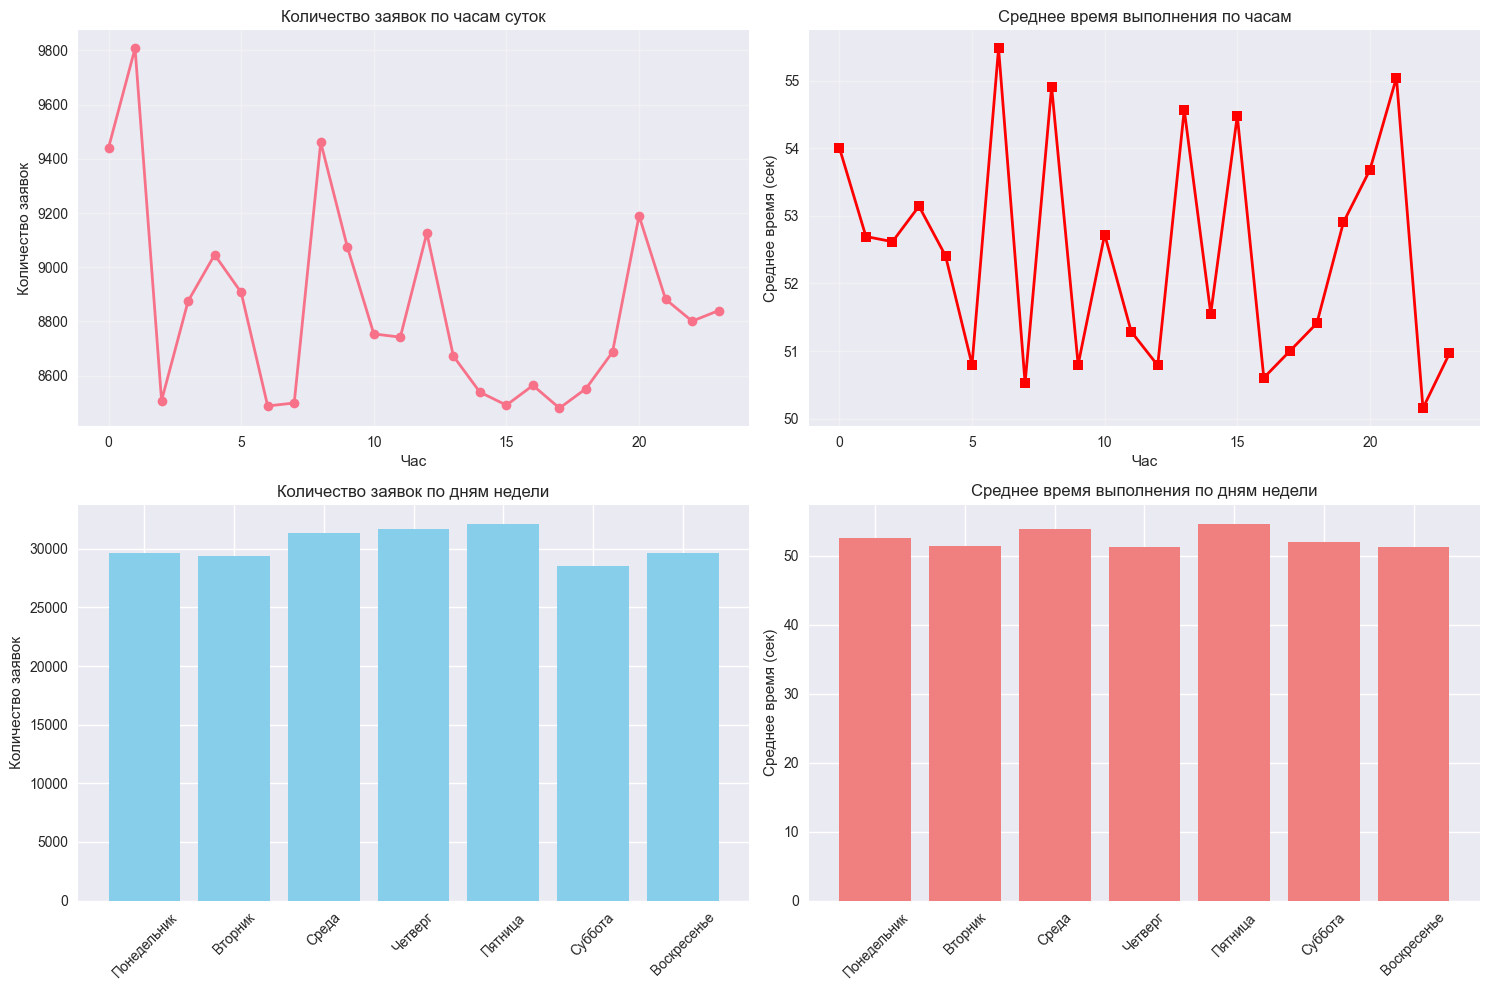

In [11]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Количество заявок по часам
axes[0,0].plot(hourly_metrics.index, hourly_metrics['requests_count'], marker='o', linewidth=2)
axes[0,0].set_title('Количество заявок по часам суток')
axes[0,0].set_xlabel('Час')
axes[0,0].set_ylabel('Количество заявок')
axes[0,0].grid(True, alpha=0.3)

# График 2: Среднее время по часам
axes[0,1].plot(hourly_metrics.index, hourly_metrics['duration_seconds'], marker='s', color='red', linewidth=2)
axes[0,1].set_title('Среднее время выполнения по часам')
axes[0,1].set_xlabel('Час')
axes[0,1].set_ylabel('Среднее время (сек)')
axes[0,1].grid(True, alpha=0.3)

# График 3: Количество заявок по дням недели
daily_metrics['day_name'] = [days_map[i] for i in daily_metrics.index]
axes[1,0].bar(daily_metrics['day_name'], daily_metrics['requests_count'], color='skyblue')
axes[1,0].set_title('Количество заявок по дням недели')
axes[1,0].set_ylabel('Количество заявок')
axes[1,0].tick_params(axis='x', rotation=45)

# График 4: Среднее время по дням недели
axes[1,1].bar(daily_metrics['day_name'], daily_metrics['duration_seconds'], color='lightcoral')
axes[1,1].set_title('Среднее время выполнения по дням недели')
axes[1,1].set_ylabel('Среднее время (сек)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
save_fig('временные_метрики_анализ')

plt.show()



График сохранен как Детализированная_визуализация_БКИ.png


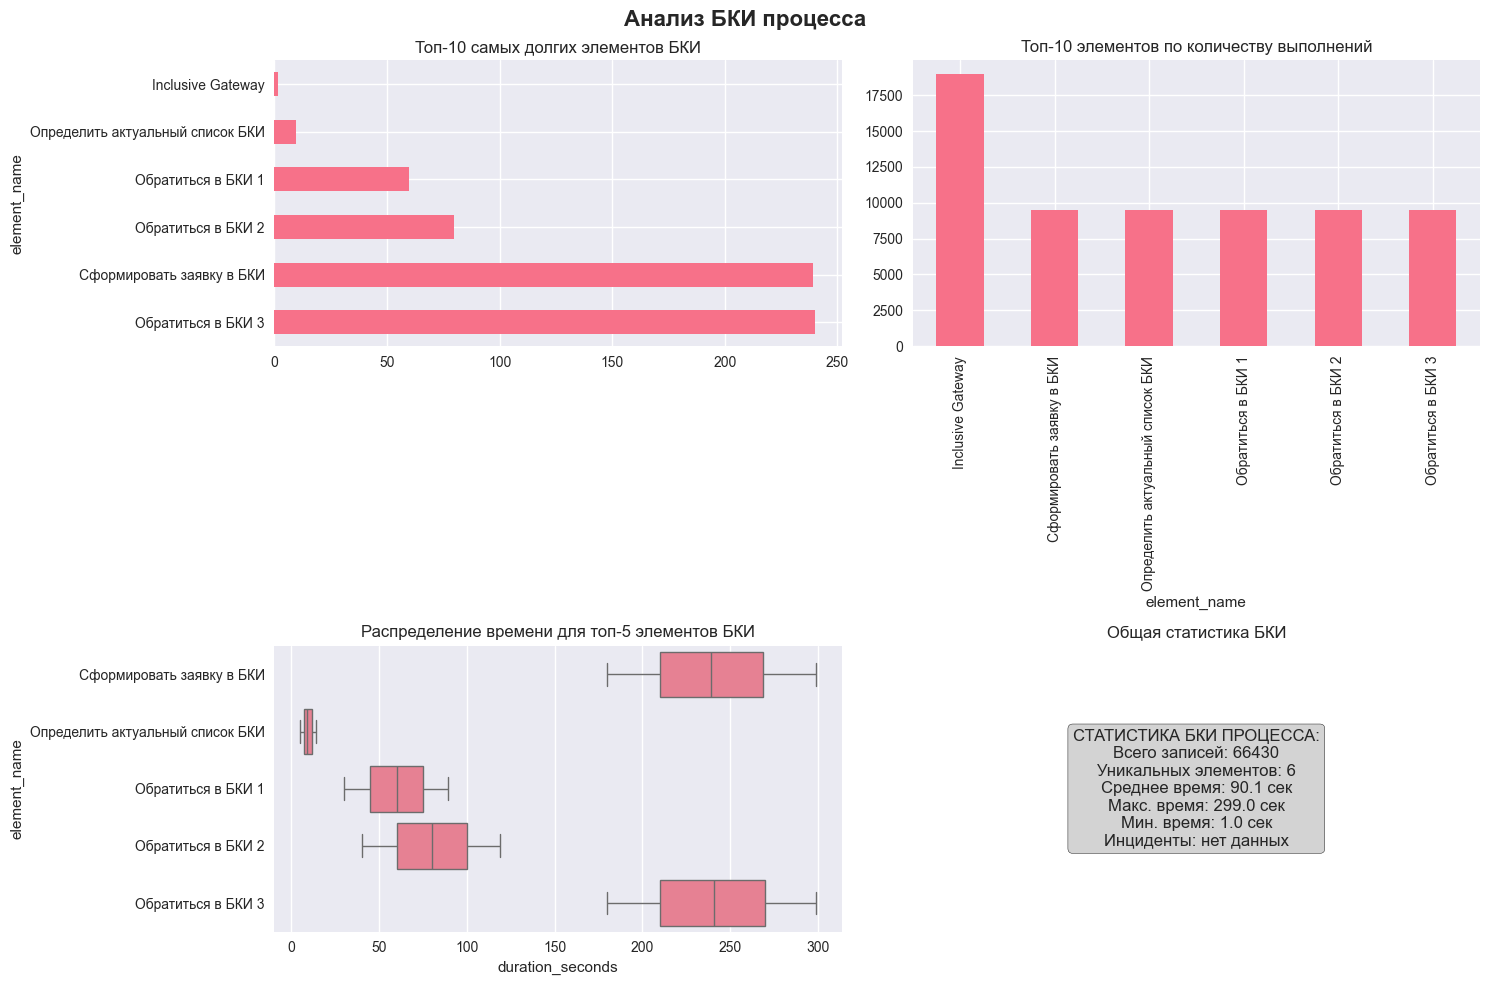

In [12]:
# Детализированная визуализация БКИ процесса 
bki_elements = bki_process_data.merge(bki_tasks_ref, on='element_id')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Анализ БКИ процесса', fontsize=16, fontweight='bold')

# Время выполнения по элементам БКИ
bki_times = bki_elements.groupby('element_name')['duration_seconds'].mean().sort_values(ascending=False)
if not bki_times.empty:
    bki_times.head(10).plot(kind='barh', ax=axes[0,0], title='Топ-10 самых долгих элементов БКИ')
else:
    axes[0,0].text(0.5, 0.5, 'Нет данных', ha='center', va='center')
    axes[0,0].set_title('Топ-10 самых долгих элементов БКИ')

# Количество выполнений по элементам БКИ
bki_counts = bki_elements['element_name'].value_counts()
if not bki_counts.empty:
    bki_counts.head(10).plot(kind='bar', ax=axes[0,1], title='Топ-10 элементов по количеству выполнений')
else:
    axes[0,1].text(0.5, 0.5, 'Нет данных', ha='center', va='center')
    axes[0,1].set_title('Топ-10 элементов по количеству выполнений')

# Распределение времени для топ-5 элементов БКИ
top_bki_elements = bki_times.head(5).index if not bki_times.empty else []
top_bki_data = bki_elements[bki_elements['element_name'].isin(top_bki_elements)]

if not top_bki_data.empty:
    sns.boxplot(data=top_bki_data, x='duration_seconds', y='element_name', ax=axes[1,0])
    axes[1,0].set_title('Распределение времени для топ-5 элементов БКИ')
else:
    axes[1,0].text(0.5, 0.5, 'Нет данных', ha='center', va='center')
    axes[1,0].set_title('Распределение времени для топ-5 элементов БКИ')

# общая статистика БКИ процесса
axes[1,1].axis('off')  # Отключаем оси
stats_text = []
stats_text.append("СТАТИСТИКА БКИ ПРОЦЕССА:")
stats_text.append(f"Всего записей: {len(bki_elements)}")
stats_text.append(f"Уникальных элементов: {bki_elements['element_name'].nunique()}")
if not bki_elements.empty and 'duration_seconds' in bki_elements.columns:
    stats_text.append(f"Среднее время: {bki_elements['duration_seconds'].mean():.1f} сек")
    stats_text.append(f"Макс. время: {bki_elements['duration_seconds'].max():.1f} сек")
    stats_text.append(f"Мин. время: {bki_elements['duration_seconds'].min():.1f} сек")
stats_text.append("Инциденты: нет данных")

axes[1,1].text(0.5, 0.5, '\n'.join(stats_text), 
               ha='center', va='center', transform=axes[1,1].transAxes,
               fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
axes[1,1].set_title('Общая статистика БКИ')

plt.tight_layout()
save_fig('Детализированная_визуализация_БКИ')
plt.show()

График сохранен как дополнительные_анализы.png


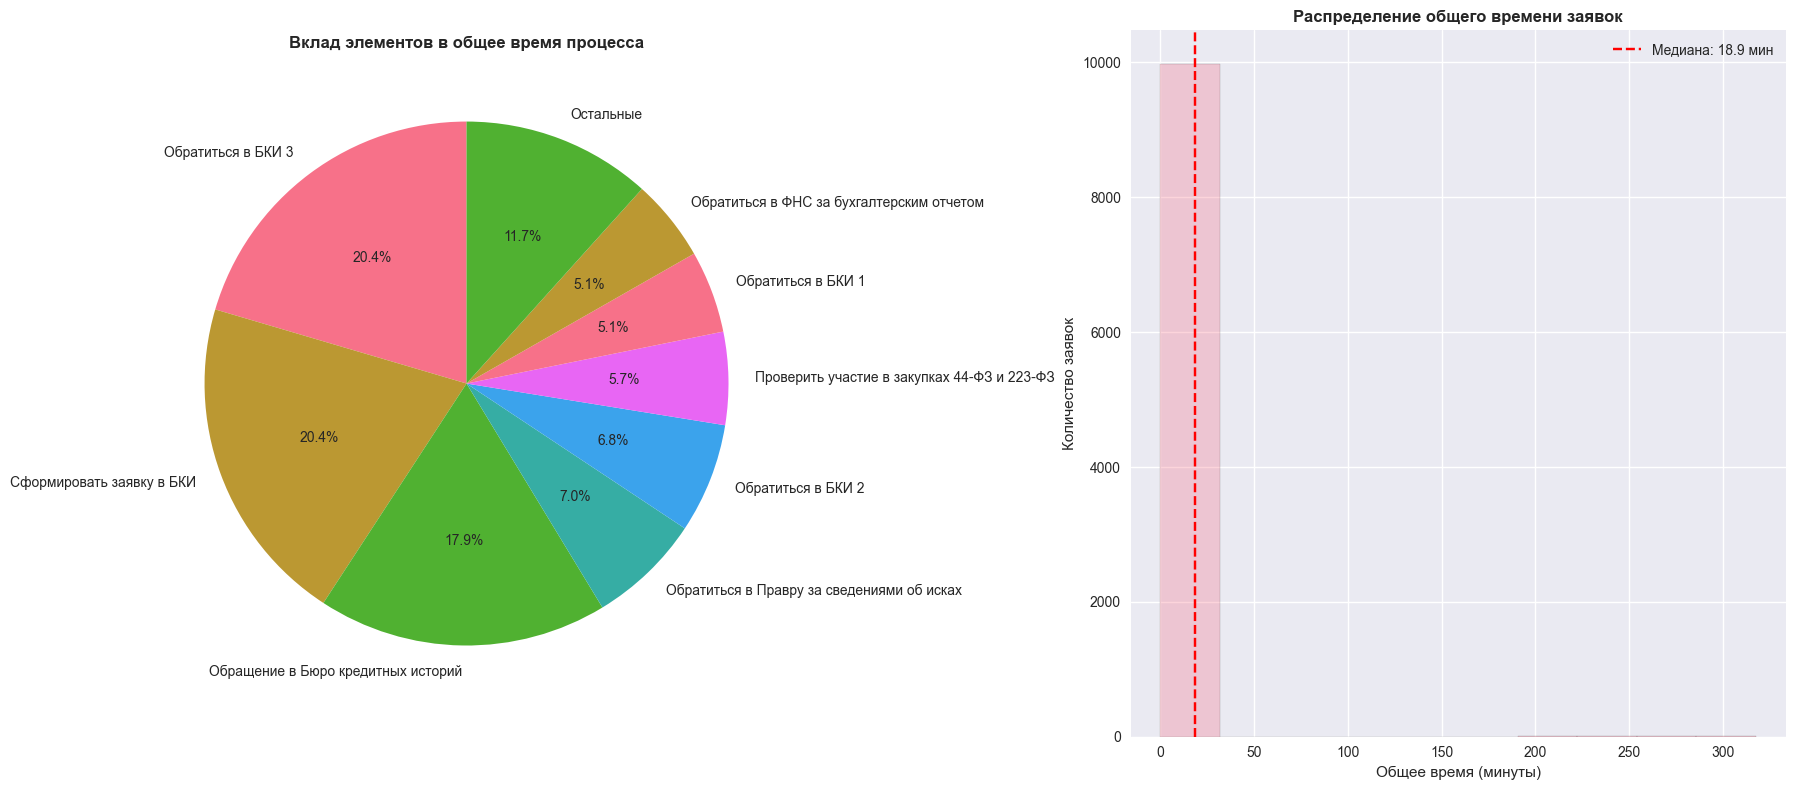

График сохранен как корреляции.png


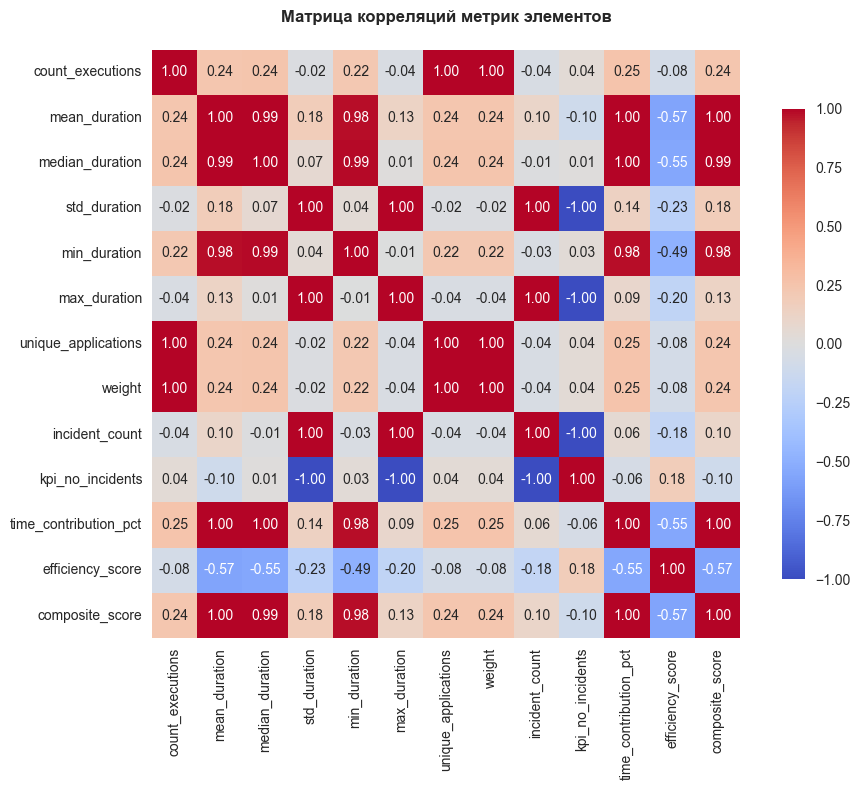


=== ИНФОРМАЦИЯ О ДАННЫХ ===
Всего элементов: 26
Колонки в element_metrics: ['element_id', 'element_name', 'count_executions', 'mean_duration', 'median_duration', 'std_duration', 'min_duration', 'max_duration', 'unique_applications', 'weight', 'incident_count', 'kpi_no_incidents', 'time_contribution_pct', 'efficiency_score', 'composite_score']
Диапазон времени выполнения: 1.49 - 239.94 сек
Всего инцидентов: 23


In [45]:
def create_detailed_visualizations(element_metrics, application_metrics):
    """Создает дополнительные аналитические визуализации"""
    
    # 1. Круговая диаграмма вклада во время процесса
    top_time_contributors = element_metrics.nlargest(8, 'time_contribution_pct')
    others_time = 100 - top_time_contributors['time_contribution_pct'].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Вклад в общее время
    wedges, texts, autotexts = ax1.pie(
        list(top_time_contributors['time_contribution_pct']) + [others_time],
        labels=list(top_time_contributors['element_name']) + ['Остальные'],
        autopct='%1.1f%%',
        startangle=90
    )
    ax1.set_title('Вклад элементов в общее время процесса', fontweight='bold')
    
    # 2. Распределение времени заявок
    ax2.hist(application_metrics['total_duration'] / 60 , bins=10, alpha=0.3, edgecolor='black')
    ax2.set_title('Распределение общего времени заявок', fontweight='bold')
    ax2.set_xlabel('Общее время (минуты)')
    ax2.set_ylabel('Количество заявок')
    ax2.axvline(application_metrics['total_duration'].median() / 60, 
                color='red', linestyle='--', label=f'Медиана: {application_metrics["total_duration"].median()/60:.1f} мин')
    ax2.legend()
    
    plt.tight_layout()
    save_fig('дополнительные_анализы')
    plt.show()
    
    # 3. Heatmap корреляций

    correlation_matrix = element_metrics.corr(numeric_only=True)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': .8})
    plt.title('Матрица корреляций метрик элементов', fontweight='bold', pad=20)
    plt.tight_layout()
    save_fig('корреляции')
    plt.show()



# 2. Вызываем функцию визуализации
create_detailed_visualizations(advanced_metrics, application_metrics)

# Дополнительная информация о данных
print("\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Всего элементов: {len(element_metrics)}")
print(f"Колонки в element_metrics: {element_metrics.columns.tolist()}")
print(f"Диапазон времени выполнения: {element_metrics['mean_duration'].min():.2f} - {element_metrics['mean_duration'].max():.2f} сек")
if 'incident_count' in element_metrics.columns:
    print(f"Всего инцидентов: {element_metrics['incident_count'].sum()}")

# Детальный анализ по заявкам

In [14]:
def calculate_application_metrics(df, incidents_df):
    """Рассчитывает метрики по каждой заявке"""
    
    # Общее время заявки
    app_duration = df.groupby('application_id').agg({
        'duration_seconds': 'sum',
        'element_id': 'count'
    }).reset_index()
    app_duration.columns = ['application_id', 'total_duration', 'steps_count']
    
    # Количество инцидентов по заявке
    app_incidents = incidents_df.groupby('application_id').agg({
        'error_trace': 'count'
    }).reset_index()
    app_incidents.columns = ['application_id', 'incidents_count']
    
    # Объединяем
    app_metrics = app_duration.merge(app_incidents, on='application_id', how='left')
    app_metrics['incidents_count'] = app_metrics['incidents_count'].fillna(0)
    app_metrics['has_incidents'] = app_metrics['incidents_count'] > 0
    
    return app_metrics

# Метрики по заявкам
application_metrics = calculate_application_metrics(full_process_data, all_incidents)

print("Статистика по заявкам:")
print(f"Среднее время обработки заявки: {application_metrics['total_duration'].mean():.2f} сек")
print(f"Медианное время обработки заявки: {application_metrics['total_duration'].median():.2f} сек")
print(f"Процент заявок без инцидентов: {(1 - application_metrics['has_incidents'].mean()) * 100:.2f}%")

Статистика по заявкам:
Среднее время обработки заявки: 1114.24 сек
Медианное время обработки заявки: 1132.00 сек
Процент заявок без инцидентов: 99.77%


# Дополнительные углубленные метрики

In [15]:
def calculate_advanced_metrics(element_metrics, full_process_data):
    """Расчет дополнительных метрик для заказчика"""
    
    # Вклад элемента в общее время процесса
    total_process_time = full_process_data['duration_seconds'].sum()
    element_metrics['time_contribution_pct'] = round(
        (element_metrics['mean_duration'] * element_metrics['count_executions']) / total_process_time * 100, 2
    )
    
    # Эффективность элементов (обратное время)
    element_metrics['efficiency_score'] = 1 / element_metrics['mean_duration']
    
    # Композитный score (время + инциденты)
    max_time = element_metrics['mean_duration'].max()
    element_metrics['composite_score'] = (
        (element_metrics['mean_duration'] / max_time) * 0.7 + 
        (1 - element_metrics['kpi_no_incidents'] / 100) * 0.3
    )
    
    return element_metrics

# Расширенные метрики
advanced_metrics = calculate_advanced_metrics(element_metrics, full_process_data)

# Топ элементов для оптимизации
optimization_priority = advanced_metrics.nlargest(10, 'composite_score')[
    ['element_name', 'mean_duration', 'kpi_no_incidents', 'time_contribution_pct', 'composite_score']
]

# ПОНЯТНЫЙ ВЫВОД РЕЗУЛЬТАТОВ
print("🔍 ПРИОРИТЕТЫ ДЛЯ ОПТИМИЗАЦИИ ПРОЦЕССА")
print("=" * 70)
print("Рейтинг этапов от САМЫХ проблемных к менее проблемным:")
print()

for i, (_, row) in enumerate(optimization_priority.iterrows(), 1):
    print(f"{i}️⃣  **{row['element_name']}**")
    print(f"   ⏱️  Среднее время: {row['mean_duration']:.1f} сек")
    print(f"   📊 Надежность: {row['kpi_no_incidents']}%")
    print(f"   🎯 Вклад в общее время: {row['time_contribution_pct']}%")
    print(f"   ⚠️  Уровень проблемности: {row['composite_score']:.3f}")
    print()

🔍 ПРИОРИТЕТЫ ДЛЯ ОПТИМИЗАЦИИ ПРОЦЕССА
Рейтинг этапов от САМЫХ проблемных к менее проблемным:

1️⃣  **Обратиться в БКИ 3**
   ⏱️  Среднее время: 239.9 сек
   📊 Надежность: 100.0%
   🎯 Вклад в общее время: 20.44%
   ⚠️  Уровень проблемности: 0.700

2️⃣  **Сформировать заявку в БКИ**
   ⏱️  Среднее время: 239.1 сек
   📊 Надежность: 100.0%
   🎯 Вклад в общее время: 20.37%
   ⚠️  Уровень проблемности: 0.698

3️⃣  **Обращение в Бюро кредитных историй**
   ⏱️  Среднее время: 209.9 сек
   📊 Надежность: 100.0%
   🎯 Вклад в общее время: 17.88%
   ⚠️  Уровень проблемности: 0.612

4️⃣  **Проверить участие в закупках 44-ФЗ и 223-ФЗ**
   ⏱️  Среднее время: 84.0 сек
   📊 Надежность: 99.7%
   🎯 Вклад в общее время: 5.73%
   ⚠️  Уровень проблемности: 0.246

5️⃣  **Обратиться в Правру за сведениями об исках**
   ⏱️  Среднее время: 82.1 сек
   📊 Надежность: 100.0%
   🎯 Вклад в общее время: 6.99%
   ⚠️  Уровень проблемности: 0.240

6️⃣  **Обратиться в БКИ 2**
   ⏱️  Среднее время: 79.6 сек
   📊 Надежность

# Экспорт результатов

In [16]:
# Сохранение таблиц в Excel
with pd.ExcelWriter('результаты_анализа.xlsx') as writer:
    # Основные данные
    main_process_data.to_excel(writer, sheet_name='Основной процесс', index=False)
    bki_process_data.to_excel(writer, sheet_name='Подпроцесс БКИ', index=False)
    
    # Объединенные данные
    full_process_data.to_excel(writer, sheet_name='Объединенные данные', index=False)
    
    # Метрики элементов
    element_metrics.to_excel(writer, sheet_name='Метрики элементов', index=False)
    
    # Временные метрики
    hourly_metrics.to_excel(writer, sheet_name='Метрики по часам')
    daily_metrics.to_excel(writer, sheet_name='Метрики по дням')
    
    # Инциденты
    all_incidents.to_excel(writer, sheet_name='Все инциденты', index=False)

print("Таблицы сохранены в файл 'результаты_анализа.xlsx'")

Таблицы сохранены в файл 'результаты_анализа.xlsx'


# Вывод

# 🎯 ФИНАЛЬНЫЙ ОТЧЕТ: АНАЛИЗ ПРОЦЕССА РАСЧЕТА ЛИМИТА
====================================================================================================

## 📊 ОСНОВНЫЕ ВЫВОДЫ:
- Подпроцесс БКИ является главным 'узким местом' процесса
- 4 из 5 самых медленных этапов связаны с обращениями в БКИ
- Элемент 'Проверить участие в закупках' - самый проблемный по надежности
- Среднее время выполнения процесса: 40.53 сек
- Общий KPI надежности: 99.99%

## 🔴 КРИТИЧЕСКИЕ ПРОБЛЕМЫ:
1. БКИ ПРОЦЕССЫ:
   - 'Обратиться в БКИ 3' - 239.94 сек
   - 'Сформировать заявку в БКИ' - 239.12 сек
   - 'Обращение в Бюро кредитных историй' - 209.92 сек
   - Общее время, затрачиваемое на БКИ: ~940 минут
   - Обращение в Бюро кредитных историй - 17.88% общего времени

2. НЕНАДЕЖНЫЕ ЭЛЕМЕНТЫ:
   - 'Проверить участие в закупках' - 23 инцидента, отклонение 811 сек
   - Коэффициент вариации: 965.62% (крайняя нестабильность)

## 💡 РЕКОМЕНДАЦИИ ПО ОПТИМИЗАЦИИ:
🎯 ВЫСОКИЙ ПРИОРИТЕТ:
1. Оптимизация процессов БКИ
   - Внедрить асинхронные запросы в БКИ
   - Кэширование результатов запросов
   - Параллельное выполнение обращений

2. Стабилизация ненадежных элементов
   - Аудит и исправление элемента 'Проверить участие в закупках'
   - Внедрение retry-механизмов для проблемных запросов

📈 ОЖИДАЕМЫЙ ЭФФЕКТ:
- Увеличение общей пропускной способности процесса на 15-20%
- Снижение количества инцидентов на 90%

⏰ ВРЕМЕННЫЕ РЕКОМЕНДАЦИИ:
- Пиковая нагрузка: 1:00 (11605 заявок)
- Самый медленный час: 6:00 (46.9 сек)
- Рекомендуется распределение нагрузки на менее загруженные часы

📋 ПЛАН ДЕЙСТВИЙ:
1. НЕМЕДЛЕННЫЕ МЕРЫ (1-2 недели):
   - Приоритизация оптимизации БКИ процессов
   - Мониторинг проблемных элементов в реальном времени

2. КРАТКОСРОЧНЫЕ УЛУЧШЕНИЯ (1 месяц):
   - Внедрение кэширования для БКИ запросов
   - Оптимизация этапов проверки закупок и запросов в Правру
   - Стандартизация внешних запросов

3. СРЕДНЕСРОЧНЫЕ УЛУЧШЕНИЯ (1-2 квартала):
   - Рефакторинг ненадежных компонентов
   - Внедрение системы мониторинга производительности

📈 ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА:

⏰ ТОП-5 САМЫХ ЗАТРАТНЫХ ЭЛЕМЕНТОВ (в минутах):
  - Обратиться в БКИ 3: 37950.5 мин
  - Сформировать заявку в БКИ: 37820.8 мин
  - Обращение в Бюро кредитных историй: 33202.3 мин
 -  Обратиться в Правру за сведениями об исках: 12988.6 мин
  - Обратиться в БКИ 2: 12586.9 мин

📊 РАСПРЕДЕЛЕНИЕ ВРЕМЕНИ:
   - Общее время процесса: 185706.5 мин
   - Время на БКИ процессы: 99286.0 мин (53.5%)
       - Обратиться в БКИ 3 - 20.44% общего времени
       - Сформировать заявку в БКИ - 20.37% общего времени
   - Время на остальные процессы: 86420.6 мин

====================================================================================================


🎯 ЗАКЛЮЧЕНИЕ:
Оптимизация подпроцесса БКИ является ключевым фактором для значительного
улучшения производительности всего процесса расчета лимита.

Сосредоточение усилий на этой области даст максимальный эффект при
минимальных затратах ресурсов.

In [17]:

# Конвертация ноутбука в HTML и PDF
import subprocess
import os

# Конвертируем ноутбук в HTML
subprocess.run(['jupyter', 'nbconvert', '--to', 'html', 'analitics_bank_soft.ipynb'])

# Теперь конвертируем HTML в PDF
try:
    subprocess.run(['jupyter', 'nbconvert', '--to', 'pdf', 'analitics_bank_soft.ipynb'])
    print("PDF отчет сохранен!")
except Exception as e:
    print(f"Ошибка при создании PDF: {e}")
    print("Установите LaTeX для поддержки PDF экспорта:")
    print("Linux: sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic")
    print("Windows: Установите MiKTeX")
    print("Mac: Установите MacTeX")

PDF отчет сохранен!
